# Zummit Africa Project

# Problem Statement #

***Given a group of sentences or paragraphs, used as a comment by a user in an online platform<br>classify it to belong to one or more of the following categories — toxic, severe-toxic, obscene, threat,<br>insult or identity-hate with either approximate probabilities or discrete values (0/1).***

In [1]:
#import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score
import warnings
warnings.filterwarnings("ignore")

C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load the dataset
df = pd.read_csv(r'C:\Users\HP\Desktop\Data Science\toxic_comments\train.csv')

In [3]:
# check the dataframe
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# check data general infomation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
# check for null or missing values
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
# print the statistical analysis
df.describe().T

,count,mean,std,min,25%,50%,75%,max
toxic,159571.0,0.095844,0.294379,0.0,0.0,0.0,0.0,1.0
severe_toxic,159571.0,0.009996,0.099477,0.0,0.0,0.0,0.0,1.0
obscene,159571.0,0.052948,0.223931,0.0,0.0,0.0,0.0,1.0
threat,159571.0,0.002996,0.054650,0.0,0.0,0.0,0.0,1.0
insult,159571.0,0.049364,0.216627,0.0,0.0,0.0,0.0,1.0
identity_hate,159571.0,0.008805,0.093420,0.0,0.0,0.0,0.0,1.0


### Exploratory Data Analysis

In [7]:
# perform a value count for each column feature
# locate or define a numeric function for plotting
sentence_col=df.iloc[:,2:].sum()
sentence_col

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

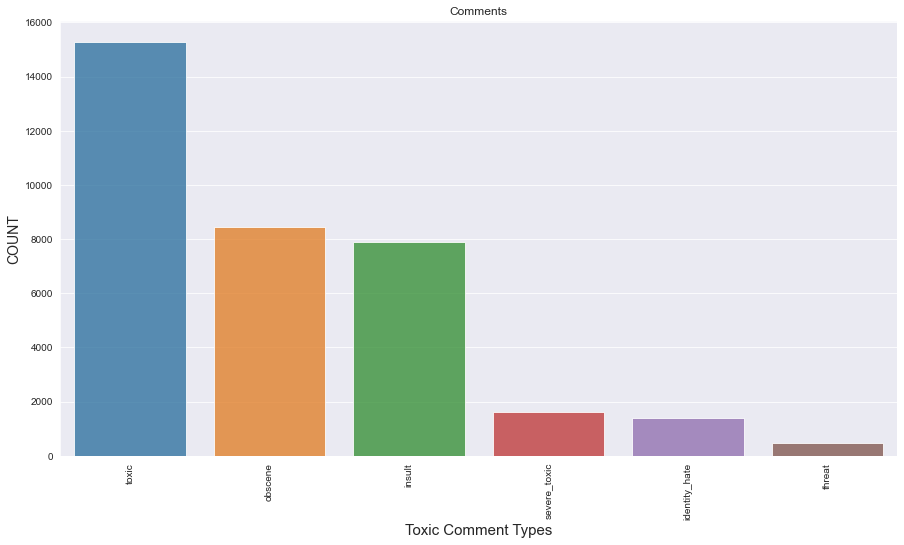

In [8]:
# plot the graph of value count
sns.set_style("darkgrid")
ls=sentence_col.sort_values(ascending=False)
plt.figure(figsize=(15,8))
temp =sns.barplot(ls.index, ls.values, alpha=0.8) 
plt.title('Comments')
plt.ylabel('COUNT', fontsize=14)
plt.xlabel('Toxic Comment Types', fontsize=15)
temp.set_xticklabels(rotation=90,labels=ls.index,fontsize=10)
plt.show()

<AxesSubplot:xlabel='toxic', ylabel='count'>

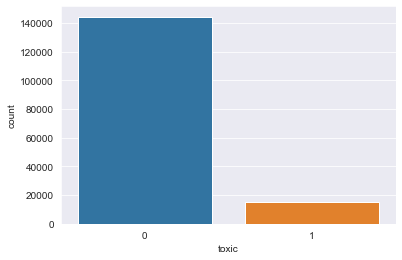

In [9]:
# count plot of each feature
sns.countplot(df['toxic'])

<AxesSubplot:xlabel='obscene', ylabel='count'>

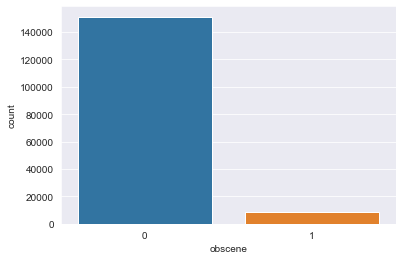

In [10]:
# count plot of each feature
sns.countplot(df['obscene'])

<AxesSubplot:xlabel='insult', ylabel='count'>

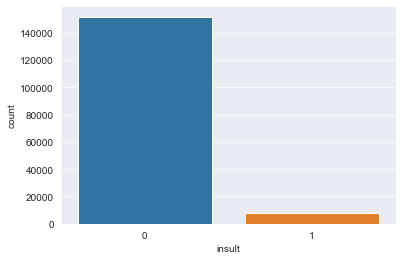

In [11]:
# count plot of each feature
sns.countplot(df['insult'])

<AxesSubplot:xlabel='severe_toxic', ylabel='count'>

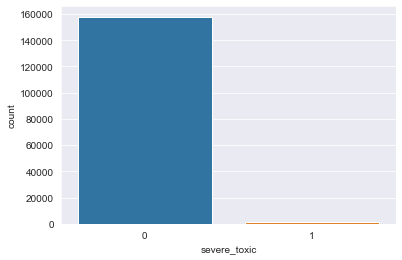

In [12]:
# count plot of each feature
sns.countplot(df['severe_toxic'])

<AxesSubplot:xlabel='identity_hate', ylabel='count'>

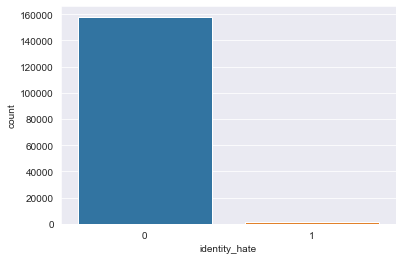

In [13]:
# count plot of each feature
sns.countplot(df['identity_hate'])

<AxesSubplot:xlabel='threat', ylabel='count'>

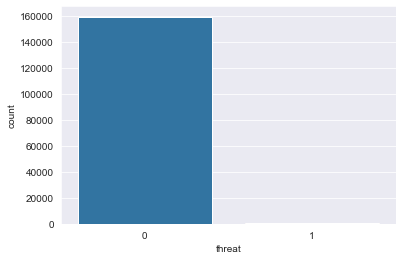

In [14]:
# count plot of each feature
sns.countplot(df['threat'])

***Obviously we have maximum values of zero and minimum values of 1, based on the analysis above.*** 

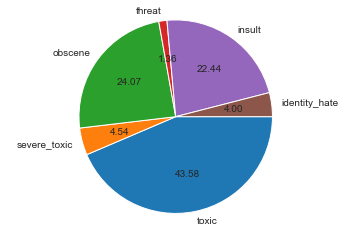

In [15]:
# visualize comment percentage
plt.pie(sentence_col.values,labels=sentence_col.index,autopct='%.2f',counterclock=False)
plt.axis('equal')
plt.show()

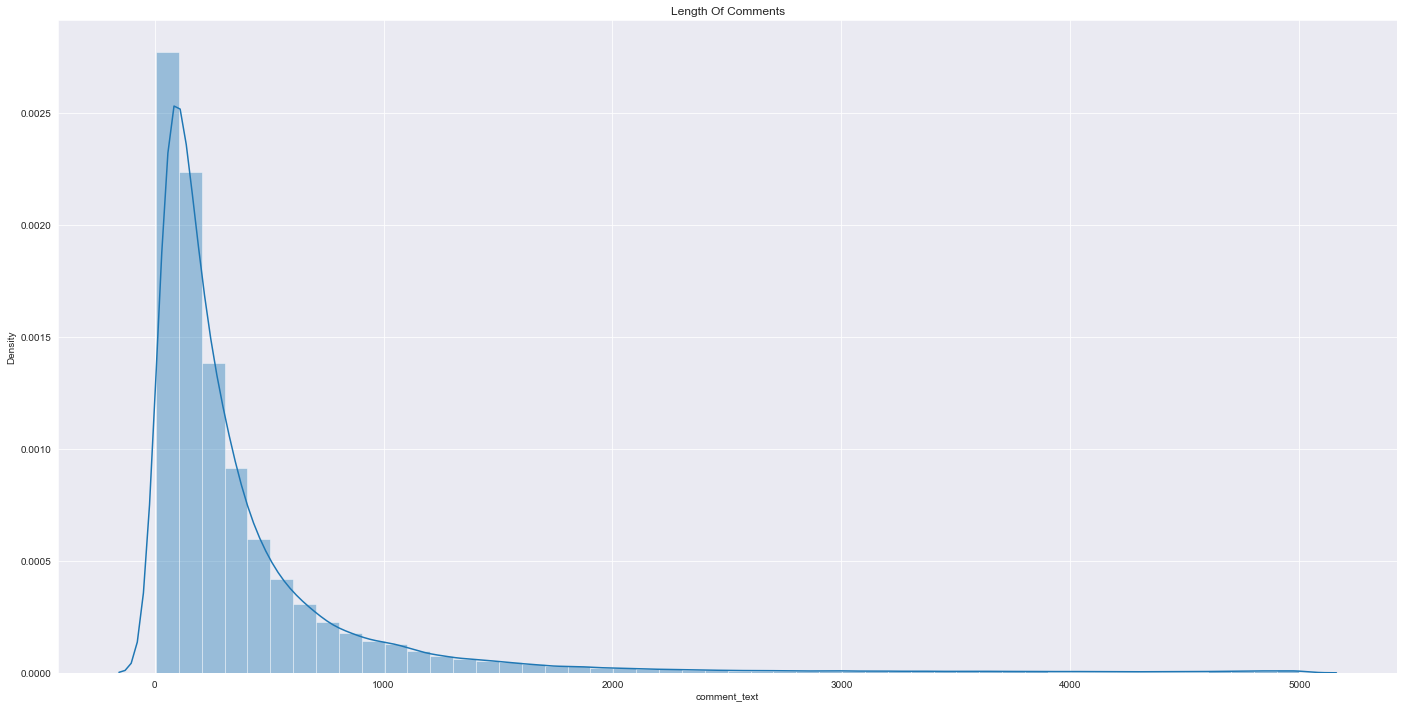

In [16]:
# plot comment_text length distribution
plt.figure(figsize = (24,12))
sns.distplot(df["comment_text"].apply(lambda x : len(x)))
plt.title("Length Of Comments")
plt.show()

***The distribution curve is skewed to the right, which indicte the uneven spread of data***

### Data Pre-processing

In [17]:
# clean the text by removing punctuation and stopword
# convert abbreviations to full text
# remove special character
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
df['comment_text'] = df['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [18]:
df['comment_text']

0         explanation why the edits made under my userna...
1         d aww  he matches this background colour i m s...
2         hey man  i m really not trying to edit war  it...
3           more i can t make any real suggestions on im...
4         you  sir  are my hero  any chance you remember...
                                ...                        
159566          and for the second time of asking  when ...
159567    you should be ashamed of yourself   that is a ...
159568    spitzer   umm  theres no actual article for pr...
159569    and it looks like it was actually you who put ...
159570      and     i really don t think you understand ...
Name: comment_text, Length: 159571, dtype: object

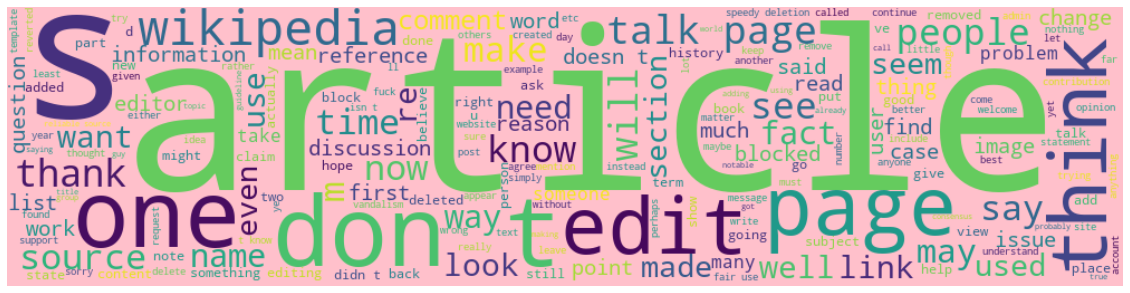

In [19]:
# plot a wordcloud for comment text
words = ' '.join([k for k in df['comment_text']])
W_C = WordCloud(width=1000, height=250, random_state=31, max_font_size=200,background_color='pink').generate(words)
plt.figure(figsize=(20,8))
plt.imshow(W_C, interpolation="bilinear")
plt.axis('off')
plt.show()

### Feature Selection and Model Building

In [20]:
# used tf_idf vectorizing technique to transform text to numerals
# here i am considering max-features as 40000 and passing bi-gram model
tf_idf = TfidfVectorizer(analyzer='word', max_features=40000, ngram_range=(1,2), stop_words='english')
# declare an independent variable
X = tf_idf.fit_transform(df['comment_text'])
X

<159571x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 4579472 stored elements in Compressed Sparse Row format>

In [21]:
# get column names
name_of_features=tf_idf.get_feature_names()
# getting list of features
name_of_features[0:10]

['aa',
 'aap',
 'aardvark',
 'aaron',
 'ab',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment']

In [22]:
# declaring the dependent variable
y=df.drop(['id', 'comment_text'], axis=1)
y.drop(['toxic'], axis=1, inplace=True)
y

,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
159566,0,0,0,0,0
159567,0,0,0,0,0
159568,0,0,0,0,0
159569,0,0,0,0,0


In [23]:
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25)

### Support Vector Classifier in OneVsRest Classifier

In [24]:
# preparing object for linear SVC
svc = LinearSVC()

In [25]:
# fixing the model in onevsrest classifier
# use one-vs-rest classifier because of multiclass classification
clf = OneVsRestClassifier(svc)

In [26]:
# fit the model to the dataset
clf.fit(X_train,y_train)

OneVsRestClassifier(estimator=LinearSVC())

In [27]:
# make prediction with the model
svc_pred= clf.predict(X_test)
svc_pred

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

### Model Validation and Evaluation

In [28]:
# print confusion matrix
cm_svc=confusion_matrix(y_test.values.argmax(axis=1),svc_pred.argmax(axis=1))
cm_svc

array([[37064,   413,    11,   108,    19],
       [  583,  1091,     4,    80,     4],
       [   26,     0,    15,     3,     0],
       [  312,    29,     3,    76,     5],
       [   35,     3,     0,     3,     6]], dtype=int64)

In [29]:
# print classification report
print(classification_report(svc_pred.argmax(axis=1),y_test.values.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     38020
           1       0.62      0.71      0.66      1536
           2       0.34      0.45      0.39        33
           3       0.18      0.28      0.22       270
           4       0.13      0.18      0.15        34

    accuracy                           0.96     39893
   macro avg       0.45      0.52      0.48     39893
weighted avg       0.96      0.96      0.96     39893



In [30]:
# check model accuracy
accuracy_svc_pred=accuracy_score(y_test.values.argmax(axis=1),svc_pred.argmax(axis=1))
accuracy_svc_pred

0.9588649637781065

In [31]:
# check the f1-score of the model
print("f1_score:",f1_score(y_test,svc_pred, average="micro"))

f1_score: 0.6757607555089191


### Model Testing

In [32]:
# Declare a comment list for testing the model
comment = ['i hate you', "you are a good boy", "you are an asshole"]

In [33]:
# tranform the comments to vectors
xt = tf_idf.transform(comment)
xt

<3x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [34]:
# make the prediction
category=clf.predict(xt)
category

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0]])

In [35]:
# create a df for the prediction class
col=[ 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
cat = pd.DataFrame(category,columns=col)
cat

,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0
1,0,0,0,0,0
2,0,1,0,1,0


In [36]:
# print prediction
for i in range(len(cat)):
    if cat.columns[(cat == 1).iloc[i]].notna().all():
        print(cat.columns[(cat == 1).iloc[i]].values)

[]
[]
['obscene' 'insult']


### Create a pipeline for the model

In [37]:
#import the library
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer

In [38]:
pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(lowercase=True,
                                                      max_features=1000,
                                                      stop_words= ENGLISH_STOP_WORDS)),
                            ('model', OneVsRestClassifier(LinearSVC()))])

In [39]:
# fit the model into the pipeline
pipeline.fit(df.comment_text, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
           

In [40]:
# make prediction with the pipeline
pipeline.predict(df.comment_text)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [41]:
# create a word list for prediction test
word=["eat shit and die"]

In [42]:
# check prediction
pipeline.predict(word)

array([[0, 1, 0, 1, 0]])

### Save or Dump the Model Using Joblib

In [43]:
# import the library
from joblib import dump

In [44]:
# save now
dump(pipeline, filename="toxic_comment_classification.joblib")

['toxic_comment_classification.joblib']